In [2]:
# Cell 1: Imports

import os
import zipfile
import glob

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:

DATA_ROOT   = "../../CSI_Detection/csi_dataset"
print(f"Data root:", DATA_ROOT)

for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files[:6]:
        print(f"{subindent}{f}") # Print only first 5 files for brevity

Data root: ../../CSI_Detection/csi_dataset
csi_dataset/
  csi_windows_w64_s32.pt
  movement/
    csi_labeled_20260209_165435.csv
    csi_labeled_20260209_165650.csv
    csi_labeled_20260209_165528.csv
    csi_labeled_20260209_165338.csv
    csi_labeled_20260209_165613.csv
  static/
    csi_labeled_20260209_164513.csv
    csi_labeled_20260209_164354.csv
    csi_labeled_20260209_164435.csv
    csi_labeled_20260209_164635.csv
    csi_labeled_20260209_164556.csv
  no_human/
    csi_labeled_20260209_162943.csv
    csi_labeled_20260209_162458.csv
    csi_labeled_20260209_162733.csv
    csi_labeled_20260209_162632.csv
    csi_labeled_20260209_162543.csv


In [4]:
csv_files = glob.glob(os.path.join(DATA_ROOT, "**", "*.csv"), recursive=True)
print("Found CSV files:", len(csv_files))

if len(csv_files) == 0:
    raise RuntimeError("No file in .csv pleas check DATA_ROOT again")

dfs = []
for path in csv_files:
    try:
        df = pd.read_csv(path)
        df["source_file"] = os.path.basename(path)   # เก็บชื่อไฟล์ไว้ดูทีหลัง
        dfs.append(df)
    except Exception as e:
        print("❌ Error reading:", path, "|", e)

df_all = pd.concat(dfs, ignore_index=True)
print("Combined shape:", df_all.shape)
df_all.head()

Found CSV files: 15
Combined shape: (3133, 61)


,timestamp,label,rssi,noise_floor,channel,fft_gain,agc_gain,amp_0,amp_1,amp_2,...,amp_44,amp_45,amp_46,amp_47,amp_48,amp_49,amp_50,amp_51,amp_52,source_file
0,707760646,2,-52,-98,40,-36,54,13.928389,13.892444,14.212670,...,18.248287,18.110771,17.117243,16.124516,15.033297,15.132746,15.132746,14.142136,14.317822,csi_labeled_20260209_165435.csv
1,709808100,2,-52,-98,40,-35,53,11.000000,11.401754,11.180340,...,20.615528,19.924858,19.646885,19.104973,19.000000,18.000000,17.117243,16.492422,15.231546,csi_labeled_20260209_165435.csv
2,709818145,2,-52,-98,40,-36,54,10.000000,9.899495,10.630146,...,19.416489,19.416489,19.416489,17.464251,16.278820,16.278820,15.297058,16.124516,15.132746,csi_labeled_20260209_165435.csv
3,709826738,2,-52,-98,40,-36,54,11.401754,10.630146,10.630146,...,18.439089,17.804493,17.804493,17.804493,16.401220,16.401220,16.401220,16.401220,15.811389,csi_labeled_20260209_165435.csv
4,709839072,2,-51,-98,40,-34,52,12.206555,11.401754,12.727921,...,22.022717,21.260292,21.260292,21.260292,20.518286,20.518286,20.518286,19.798990,19.104973,csi_labeled_20260209_165435.csv


Columns: ['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_28', 'amp_29', 'amp_30', 'amp_31', 'amp_32', 'amp_33', 'amp_34', 'amp_35', 'amp_36', 'amp_37', 'amp_38', 'amp_39', 'amp_40', 'amp_41', 'amp_42', 'amp_43', 'amp_44', 'amp_45', 'amp_46', 'amp_47', 'amp_48', 'amp_49', 'amp_50', 'amp_51', 'amp_52', 'source_file']

Label value counts:
label
1    1381
2    1305
0     447
Name: count, dtype: int64


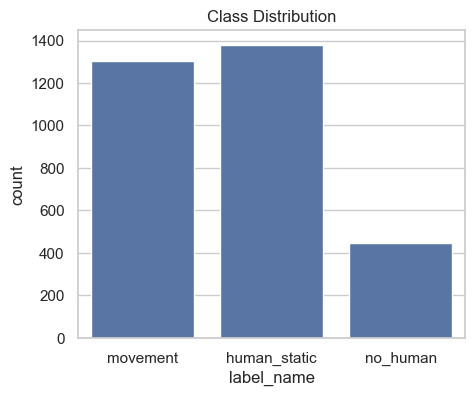

In [5]:
# Cell 4: Basic info & label distribution

print("Columns:", df_all.columns.tolist())
print()
print("Label value counts:")
print(df_all["label"].value_counts())

label_map = {0: "no_human", 1: "human_static", 2: "movement"}
df_all["label_name"] = df_all["label"].map(label_map)

plt.figure(figsize=(5,4))
sns.countplot(data=df_all, x="label_name")
plt.title("Class Distribution")
plt.show()

In [6]:
# Cell 5: Build X and y

# เลือกเฉพาะคอลัมน์ที่เป็นตัวเลข
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

# ตัดคอลัมน์ที่ไม่ใช่ feature
drop_cols = ["label", "timestamp"]  # ถ้าไม่มี timestamp ไม่เป็นไร เดี๋ยว ignore ด้านล่าง
drop_cols = [c for c in drop_cols if c in num_cols]

feature_cols = [c for c in num_cols if c not in drop_cols]

print("Number of features:", len(feature_cols))
print("Example feature cols:", feature_cols[:10])

X = df_all[feature_cols].values.astype(np.float32)
y = df_all["label"].values.astype(np.int64)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y unique:", np.unique(y))

Numeric columns: ['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_28', 'amp_29', 'amp_30', 'amp_31', 'amp_32', 'amp_33', 'amp_34', 'amp_35', 'amp_36', 'amp_37', 'amp_38', 'amp_39', 'amp_40', 'amp_41', 'amp_42', 'amp_43', 'amp_44', 'amp_45', 'amp_46', 'amp_47', 'amp_48', 'amp_49', 'amp_50', 'amp_51', 'amp_52']
Number of features: 58
Example feature cols: ['rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4']
X shape: (3133, 58)
y shape: (3133,)
y unique: [0 1 2]


CLEAN DATA SESSIONS

In [7]:
# Cell 1: Imports

import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [8]:
# Cell 2: Dataset path (ใช้ path ของคุณ)

DATA_ROOT = "../../CSI_Detection/csi_dataset"

print("DATA_ROOT:", DATA_ROOT)

# ดูโครงสร้างโฟลเดอร์คร่าว ๆ
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files[:3]:
        print(f"{subindent}{f}")

DATA_ROOT: ../../CSI_Detection/csi_dataset
csi_dataset/
  csi_windows_w64_s32.pt
  movement/
    csi_labeled_20260209_165435.csv
    csi_labeled_20260209_165650.csv
    csi_labeled_20260209_165528.csv
  static/
    csi_labeled_20260209_164513.csv
    csi_labeled_20260209_164354.csv
    csi_labeled_20260209_164435.csv
  no_human/
    csi_labeled_20260209_162943.csv
    csi_labeled_20260209_162458.csv
    csi_labeled_20260209_162733.csv


In [9]:
# Cell 3: Load all CSV files into one DataFrame

csv_files = glob.glob(os.path.join(DATA_ROOT, "**", "*.csv"), recursive=True)
print("Found CSV files:", len(csv_files))

if len(csv_files) == 0:
    raise RuntimeError("ไม่พบไฟล์ .csv ในโฟลเดอร์นี้ ตรวจสอบ DATA_ROOT อีกที")

dfs = []
for path in csv_files:
    try:
        df = pd.read_csv(path)
        df["source_file"] = os.path.basename(path)   # เก็บชื่อไฟล์ไว้เปรียบเทียบทีหลัง
        dfs.append(df)
    except Exception as e:
        print("❌ Error reading:", path, "|", e)

df_all = pd.concat(dfs, ignore_index=True)
print("Combined shape:", df_all.shape)
df_all.head()

Found CSV files: 15
Combined shape: (3133, 61)


,timestamp,label,rssi,noise_floor,channel,fft_gain,agc_gain,amp_0,amp_1,amp_2,...,amp_44,amp_45,amp_46,amp_47,amp_48,amp_49,amp_50,amp_51,amp_52,source_file
0,707760646,2,-52,-98,40,-36,54,13.928389,13.892444,14.212670,...,18.248287,18.110771,17.117243,16.124516,15.033297,15.132746,15.132746,14.142136,14.317822,csi_labeled_20260209_165435.csv
1,709808100,2,-52,-98,40,-35,53,11.000000,11.401754,11.180340,...,20.615528,19.924858,19.646885,19.104973,19.000000,18.000000,17.117243,16.492422,15.231546,csi_labeled_20260209_165435.csv
2,709818145,2,-52,-98,40,-36,54,10.000000,9.899495,10.630146,...,19.416489,19.416489,19.416489,17.464251,16.278820,16.278820,15.297058,16.124516,15.132746,csi_labeled_20260209_165435.csv
3,709826738,2,-52,-98,40,-36,54,11.401754,10.630146,10.630146,...,18.439089,17.804493,17.804493,17.804493,16.401220,16.401220,16.401220,16.401220,15.811389,csi_labeled_20260209_165435.csv
4,709839072,2,-51,-98,40,-34,52,12.206555,11.401754,12.727921,...,22.022717,21.260292,21.260292,21.260292,20.518286,20.518286,20.518286,19.798990,19.104973,csi_labeled_20260209_165435.csv


In [10]:
# Cell 4: Basic info

print("Columns:", df_all.columns.tolist())
print()

if "label" in df_all.columns:
    print("Label value counts:")
    print(df_all["label"].value_counts())
else:
    print("⚠️ No 'label' column found")

Columns: ['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_28', 'amp_29', 'amp_30', 'amp_31', 'amp_32', 'amp_33', 'amp_34', 'amp_35', 'amp_36', 'amp_37', 'amp_38', 'amp_39', 'amp_40', 'amp_41', 'amp_42', 'amp_43', 'amp_44', 'amp_45', 'amp_46', 'amp_47', 'amp_48', 'amp_49', 'amp_50', 'amp_51', 'amp_52', 'source_file']

Label value counts:
label
1    1381
2    1305
0     447
Name: count, dtype: int64


In [11]:
# Cell 5: Select numeric feature columns and backup raw data

# เก็บสำเนา raw ไว้ (เผื่อเทียบ)
df_raw = df_all.copy(deep=True)

# เลือกคอลัมน์ตัวเลขทั้งหมด
num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

# ตัดคอลัมน์ที่ไม่ใช่ feature (แล้วแต่ dataset จริงว่ามีอะไรบ้าง)
drop_cols = []
for c in ["label", "timestamp"]:
    if c in num_cols:
        drop_cols.append(c)

feature_cols = [c for c in num_cols if c not in drop_cols]

print("Number of feature columns:", len(feature_cols))
print("Example feature cols:", feature_cols[:10])

Numeric columns: ['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_28', 'amp_29', 'amp_30', 'amp_31', 'amp_32', 'amp_33', 'amp_34', 'amp_35', 'amp_36', 'amp_37', 'amp_38', 'amp_39', 'amp_40', 'amp_41', 'amp_42', 'amp_43', 'amp_44', 'amp_45', 'amp_46', 'amp_47', 'amp_48', 'amp_49', 'amp_50', 'amp_51', 'amp_52']
Number of feature columns: 58
Example feature cols: ['rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4']


In [12]:
# Cell 6: Denoising functions

def clean_numeric_df(df, feature_cols, q_low=0.001, q_high=0.999):
    """
    กรอง noise แบบเบื้องต้น:
      1. จัดการ Inf → NaN
      2. interpolate / fill NaN
      3. clip outliers ตาม quantile (เช่น 0.1% และ 99.9%)
    """
    df_clean = df.copy()

    # 1) จัดการ Inf
    for col in feature_cols:
        col_data = df_clean[col].values
        col_data = np.where(np.isinf(col_data), np.nan, col_data)
        df_clean[col] = col_data

    # 2) จัดการ NaN – เติมด้วย interpolation + ถ้ายังมี NaN ให้เติม median
    for col in feature_cols:
        series = df_clean[col]

        # ใช้ interpolation ตามลำดับ index
        series = series.interpolate(method="linear", limit_direction="both")

        # ถ้ายังมี NaN ให้ใช้ median ของคอลัมน์นั้น
        if series.isna().any():
            median_val = series.median()
            series = series.fillna(median_val)

        df_clean[col] = series

    # 3) Clip outliers ตาม quantile per column
    for col in feature_cols:
        ql = df_clean[col].quantile(q_low)
        qh = df_clean[col].quantile(q_high)
        df_clean[col] = df_clean[col].clip(ql, qh)

    return df_clean

In [13]:
# Cell 7: Apply noise filtering

df_clean = clean_numeric_df(df_all, feature_cols, q_low=0.001, q_high=0.999)

print("Raw shape   :", df_raw.shape)
print("Clean shape :", df_clean.shape)
df_clean.head()

Raw shape   : (3133, 61)
Clean shape : (3133, 61)


,timestamp,label,rssi,noise_floor,channel,fft_gain,agc_gain,amp_0,amp_1,amp_2,...,amp_44,amp_45,amp_46,amp_47,amp_48,amp_49,amp_50,amp_51,amp_52,source_file
0,707760646,2,-52.0,-98.0,40.0,-36.0,54.0,13.928389,13.892444,14.212670,...,18.248287,18.110771,17.117243,16.124516,15.033297,15.132746,15.132746,14.142136,14.317822,csi_labeled_20260209_165435.csv
1,709808100,2,-52.0,-98.0,40.0,-35.0,53.0,11.000000,11.401754,11.180340,...,20.615528,19.924858,19.646885,19.104973,19.000000,18.000000,17.117243,16.492422,15.231546,csi_labeled_20260209_165435.csv
2,709818145,2,-52.0,-98.0,40.0,-36.0,54.0,10.000000,9.899495,10.630146,...,19.416489,19.416489,19.416489,17.464251,16.278820,16.278820,15.297058,16.124516,15.132746,csi_labeled_20260209_165435.csv
3,709826738,2,-52.0,-98.0,40.0,-36.0,54.0,11.401754,10.630146,10.630146,...,18.439089,17.804493,17.804493,17.804493,16.401220,16.401220,16.401220,16.401220,15.811389,csi_labeled_20260209_165435.csv
4,709839072,2,-51.0,-98.0,40.0,-34.0,52.0,12.206555,11.401754,12.727921,...,22.022717,21.260292,21.260292,21.260292,20.518286,20.518286,20.518286,19.798990,19.104973,csi_labeled_20260209_165435.csv


In [14]:
# Cell 8: Helper to compare before vs after for a given feature

def compare_feature_before_after(col_name, n_points=500):
    """
    เปรียบเทียบ feature col_name ระหว่าง df_raw กับ df_clean
    - histogram
    - line plot (ดูแค่ n_points แรก)
    """
    if col_name not in feature_cols:
        print(f"Column '{col_name}' is not in feature_cols")
        return

    raw = df_raw[col_name].values
    clean = df_clean[col_name].values

    # 1) Histogram
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(raw, bins=80, alpha=0.6, label="raw")
    plt.hist(clean, bins=80, alpha=0.6, label="clean")
    plt.title(f"Histogram: {col_name}")
    plt.legend()

    # 2) Time-series (ตัวอย่างช่วงแรก ๆ)
    plt.subplot(1,2,2)
    idx = np.arange(min(len(raw), n_points))
    plt.plot(idx, raw[:len(idx)], label="raw", alpha=0.7)
    plt.plot(idx, clean[:len(idx)], label="clean", alpha=0.7)
    plt.title(f"First {len(idx)} points: {col_name}")
    plt.legend()

    plt.tight_layout()
    plt.show()

Amplitude columns found: ['amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9'] ...


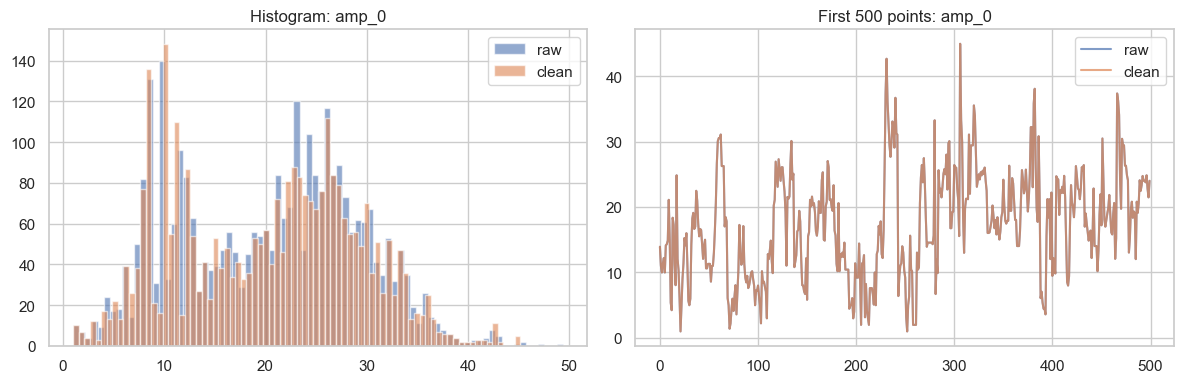

In [15]:
# Cell 9: Auto-detect amplitude columns (ถ้ามี)

amp_cols = [c for c in feature_cols if c.startswith("amp_")]
print("Amplitude columns found:", amp_cols[:10], "...")

# ถ้ามี amp_0 จริง ลองเทียบก่อน-หลัง
if len(amp_cols) > 0:
    compare_feature_before_after(amp_cols[0], n_points=500)
else:
    # ถ้าไม่มี amp_ เรียกใช้กับคอลัมน์ใดก็ได้ที่คุณสนใจ
    print("No amp_* columns found; try with any feature col, e.g.:")
    print("compare_feature_before_after(feature_cols[0])")

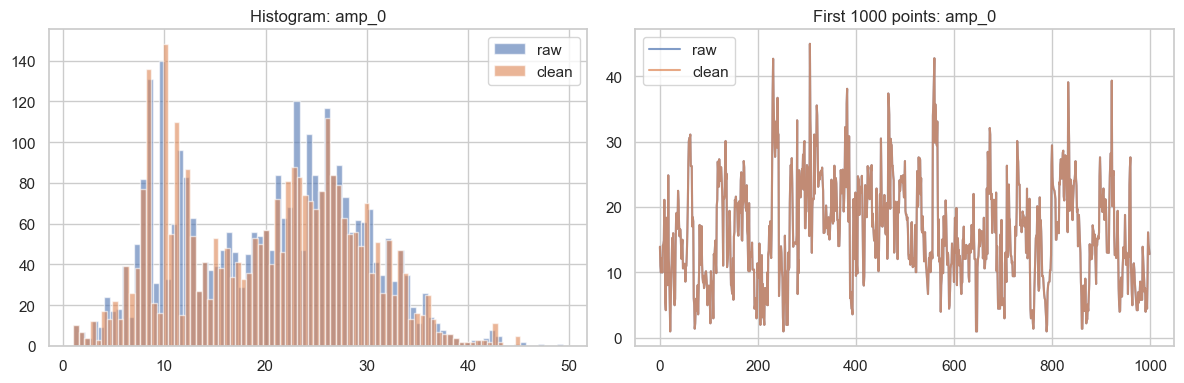

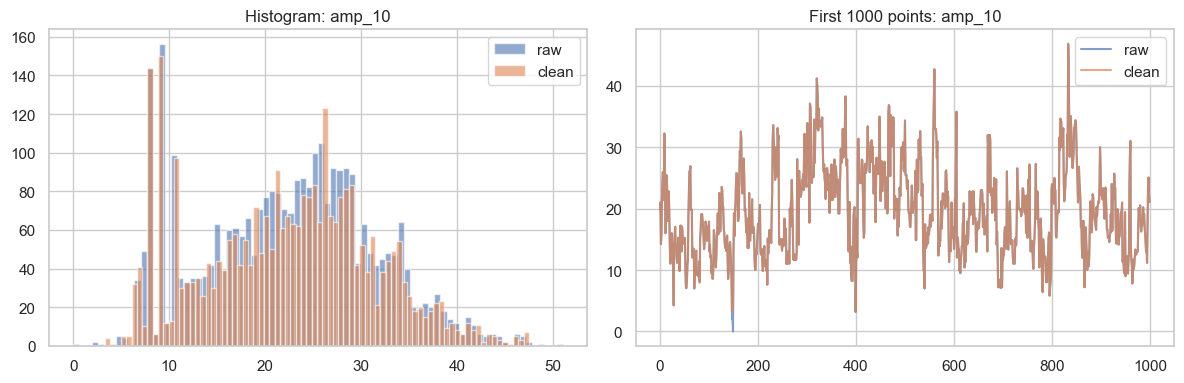

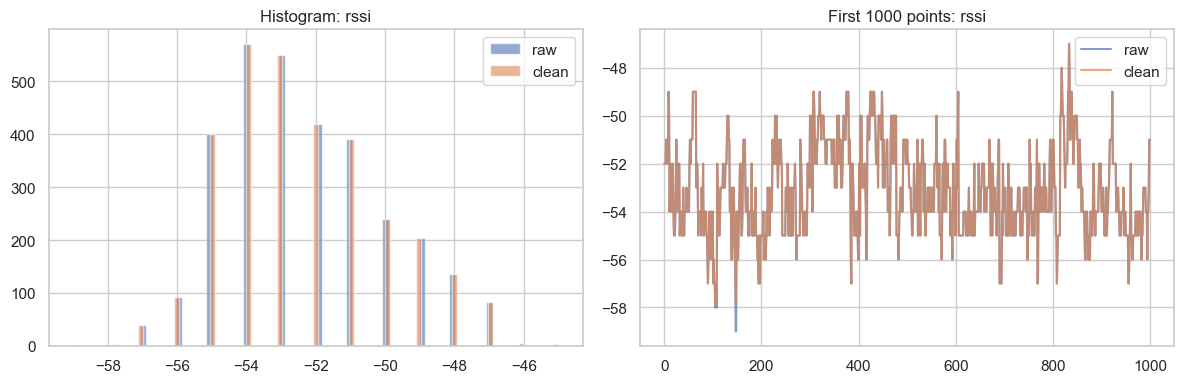

In [16]:
# ตัวอย่าง: เทียบหลาย ๆ feature
compare_feature_before_after("amp_0", n_points=1000)
compare_feature_before_after("amp_10", n_points=1000)
compare_feature_before_after(feature_cols[0], n_points=1000)  # เผื่ออยากดูอย่างอื่น

In [17]:
# Cell 10: Summary statistics before vs after

summary_rows = []
for col in feature_cols:
    raw_col = df_raw[col]
    clean_col = df_clean[col]
    summary_rows.append({
        "feature": col,
        "raw_mean": raw_col.mean(),
        "clean_mean": clean_col.mean(),
        "raw_std": raw_col.std(),
        "clean_std": clean_col.std()
    })

df_summary = pd.DataFrame(summary_rows)
df_summary.head(10)

,feature,raw_mean,clean_mean,raw_std,clean_std
0,rssi,-52.325886,-52.326036,2.286773,2.281771
1,noise_floor,-98.000000,-98.000000,0.000000,0.000000
2,channel,40.000000,40.000000,0.000000,0.000000
3,fft_gain,-36.239387,-36.240815,1.985456,1.978169
4,agc_gain,54.007660,54.007660,2.418916,2.417067
5,amp_0,20.256204,20.254132,8.922145,8.915975
6,amp_1,20.618668,20.616874,9.117569,9.109533
7,amp_2,20.780403,20.778527,9.212561,9.206503
8,amp_3,20.919307,20.917580,9.387477,9.380869
9,amp_4,21.126380,21.125281,9.437485,9.432904


In [18]:
if len(amp_cols) > 0:
    df_summary_amp = df_summary[df_summary["feature"].isin(amp_cols)]
    df_summary_amp

<Axes: xlabel='label', ylabel='amp_0'>

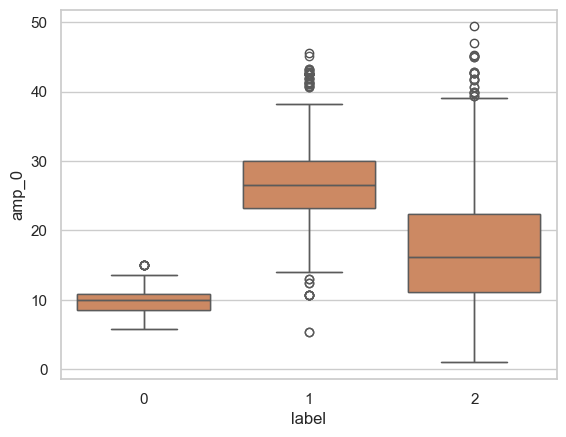

In [19]:
sns.boxplot(x="label", y="amp_0", data=df_raw)
sns.boxplot(x="label", y="amp_0", data=df_clean)

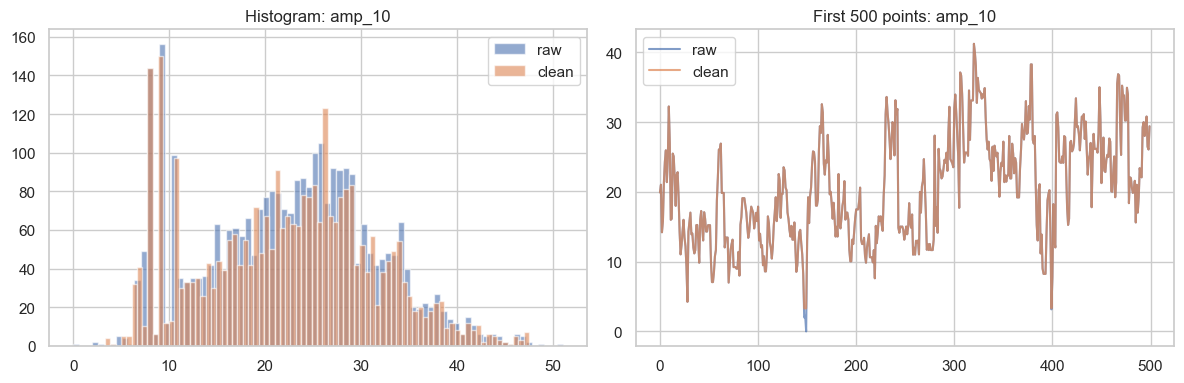

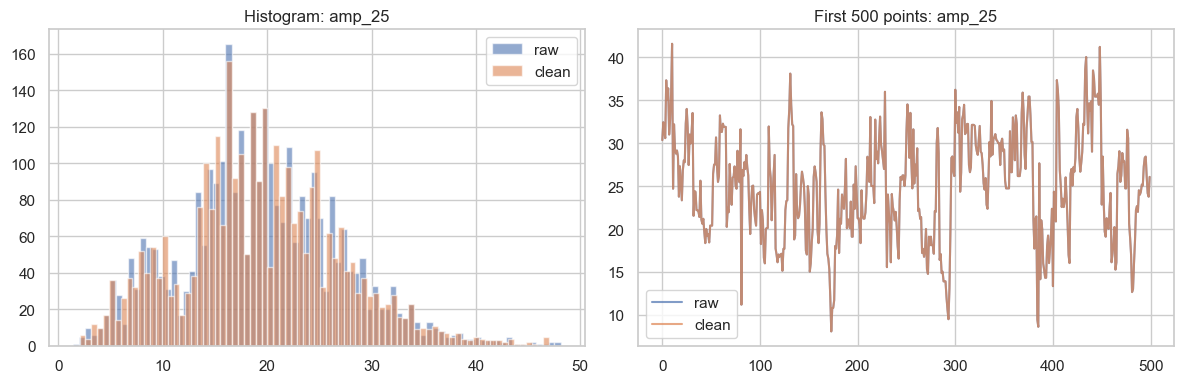

In [20]:
compare_feature_before_after("amp_10")
compare_feature_before_after("amp_25")

In [21]:
# Cell 11: Save cleaned dataset

output_path = "csi_dataset_cleaned.csv"
df_clean.to_csv(output_path, index=False)
print("✅ Saved cleaned dataset to:", output_path)

✅ Saved cleaned dataset to: csi_dataset_cleaned.csv


In [22]:
import pandas as pd

df = pd.read_csv("csi_dataset_cleaned.csv")

print("Columns:")
print(df.columns.tolist())

print("\nNumeric columns:")
print(df.select_dtypes(include="number").columns.tolist())

print("\nLabel distribution:")
print(df["label"].value_counts())

Columns:
['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_28', 'amp_29', 'amp_30', 'amp_31', 'amp_32', 'amp_33', 'amp_34', 'amp_35', 'amp_36', 'amp_37', 'amp_38', 'amp_39', 'amp_40', 'amp_41', 'amp_42', 'amp_43', 'amp_44', 'amp_45', 'amp_46', 'amp_47', 'amp_48', 'amp_49', 'amp_50', 'amp_51', 'amp_52', 'source_file']

Numeric columns:
['timestamp', 'label', 'rssi', 'noise_floor', 'channel', 'fft_gain', 'agc_gain', 'amp_0', 'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11', 'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17', 'amp_18', 'amp_19', 'amp_20', 'amp_21', 'amp_22', 'amp_23', 'amp_24', 'amp_25', 'amp_26', 'amp_27', 'amp_2